## learning-AI101 : rehab
### 캘리포니아 주택 시세 데이터를 ML, FCNN을 이용한 regression 수행

<br>

- **임규연 (lky473736)**
- 2025.07.29.에 문서 작성
- **kaggle** : https://www.kaggle.com/datasets/camnugent/california-housing-prices
- **data abstract** : This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome. The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

------

## <span id='dl'><mark>DL</mark></span>

deep learning으로 California housing price 데이터셋에서 regression을 수행한다. 목차는 아래와 같다.

- **1. 간단한 데이터 분석 및 데이터 전처리**
- **2. 모델을 적용하여 regression**
    - KNN, LR, DT, RF, SVM, XGB, Catboost, lightgbm
    - FCNN

In [20]:
!pip install kagglehub torchinfo lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [21]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

-----

### 1. 데이터 분석, 시각화 및 전처리
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- cell 순서는 아래와 같다.
    - (1) 데이터 읽기 및 head 파악, dataframe에 대한 전처리
    - (2) 데이터 info (결측치 파악), 데이터 크기
    - (3) 데이터 기초통계량 확인
    - (4) heatmap
    - (5) feature, input data split
    - (6) train set, test set, validation set split
    - (7) scaling (z-score normalization)
    - (8) DS, DL

In [22]:
# (1) 데이터 읽기 및 head 파악 및 dataframe에 대한 전처리

df = pd.read_csv ('/content/california_house_prices.csv')
print (df.columns)

df = df.drop('Unnamed: 0', axis=1)
df.head()

Index(['Unnamed: 0', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
       'Population', 'AveOccup', 'Latitude', 'Longitude', 'PRICE'],
      dtype='object')


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [23]:
# (2) data info, data shape

print ("shape : ", df.shape)
df.info()

shape :  (20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [24]:
# (3) 데이터 기초통계량 확인

df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


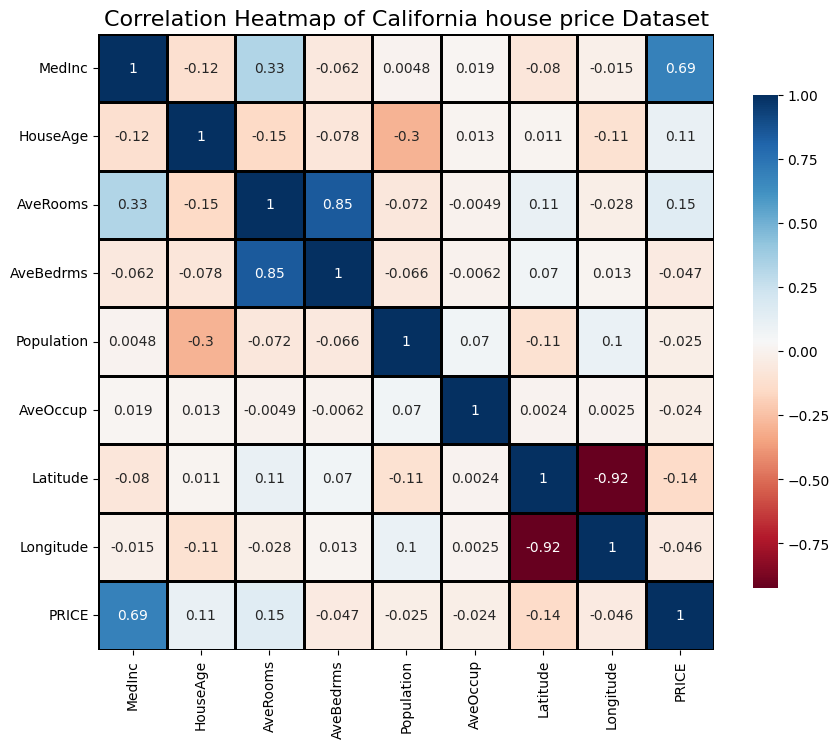

In [25]:
# (4) heatmap

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of California house price Dataset', fontsize=16)
plt.show()

In [26]:
# (5) feature, input data split

california_input = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
       'Population', 'AveOccup', 'Latitude', 'Longitude']].to_numpy()
california_target = df['PRICE'].to_numpy()

california_input.shape, california_target.shape

((20640, 8), (20640,))

In [27]:
# (6) train set, test set, validation set split

X_train, X_test, y_train, y_test = train_test_split(california_input, california_target,
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.2)

In [28]:
# (7) scaling (z-score normalization)

z_score_transformer = StandardScaler()
X_train_scaled = z_score_transformer.fit_transform(X_train)
X_test_scaled = z_score_transformer.transform(X_test)
X_val_scaled = z_score_transformer.transform(X_val)

In [45]:
# (8) DS and DL

# totorch and DataLoader

from torch.utils.data import Dataset, DataLoader

print (X_train_scaled.shape)

class cailfornia(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

train_DL = DataLoader(cailfornia(X_train_scaled, y_train),
                     shuffle=True,
                     batch_size=64)

val_DL = DataLoader(cailfornia(X_val_scaled, y_val),
                     shuffle=False,
                     batch_size=64)

test_DL = DataLoader(cailfornia(X_test_scaled,  y_test),
                     shuffle=False,
                     batch_size=64)

(13209, 8)


-------

### 2. 모델을 적용하여 regression

#### 2-1. ML
- KNN, LR, DT, RF, SVM, XGB, Catboost, lightGBM

In [30]:
# 각각의 model을 딕셔너리 형태로 정의

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

regression_models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=10),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='poly'),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=False),
    'LightGBM': LGBMRegressor(random_state=42, verbosity=-1)
}

In [31]:
# train

from sklearn.metrics import mean_squared_error, r2_score

results = {}

for name, model in regression_models.items():
    print(f"Training {name}...")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MSE': mse,
        'R2': r2
    }

    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

sorted_results = sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True)

for name, metrics in sorted_results:
    print(f"{name}: R2={metrics['R2']:.4f}, MSE={metrics['MSE']:.4f}")

Training Linear Regression...
Linear Regression - MSE: 0.5790, R2: 0.5740
Training K-Nearest Neighbors...
K-Nearest Neighbors - MSE: 0.4289, R2: 0.6845
Training Decision Tree...
Decision Tree - MSE: 0.5203, R2: 0.6173
Training Random Forest...
Random Forest - MSE: 0.2748, R2: 0.7979
Training Support Vector Regression...
Support Vector Regression - MSE: 20.5169, R2: -14.0929
Training XGBoost...
XGBoost - MSE: 0.2399, R2: 0.8235
Training CatBoost...
CatBoost - MSE: 0.2172, R2: 0.8402
Training LightGBM...
LightGBM - MSE: 0.2336, R2: 0.8281
CatBoost: R2=0.8402, MSE=0.2172
LightGBM: R2=0.8281, MSE=0.2336
XGBoost: R2=0.8235, MSE=0.2399
Random Forest: R2=0.7979, MSE=0.2748
K-Nearest Neighbors: R2=0.6845, MSE=0.4289
Decision Tree: R2=0.6173, MSE=0.5203
Linear Regression: R2=0.5740, MSE=0.5790
Support Vector Regression: R2=-14.0929, MSE=20.5169


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



#### 2-2. DNN
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 15000개 이상으로 증폭, 각 node의 activation은 relu 사용
    - epoch는 100으로 고정
- 아래와 같이 experiment할 예정이다.
    - optimizer는 **적응형 학습율 optimizer인 adam을 사용한다.**
    - validation loss 감소를 위하여 **dropout 층을 추가 후, callback으로 early stopping을 도입**한다.
        - patiences는 20으로 한다.

In [57]:
# modelling DNN

class FCNN (nn.Module) :
    def __init__ (self) :
        super().__init__()
        self.FCNN = nn.Sequential (
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 1)
        )
    def forward (self, x) :
        return self.FCNN (x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FCNN().to(device)
summary(model,
        input_size=(64, 8))

Layer (type:depth-idx)                   Output Shape              Param #
FCNN                                     [64, 1]                   --
├─Sequential: 1-1                        [64, 1]                   --
│    └─Linear: 2-1                       [64, 16]                  144
│    └─BatchNorm1d: 2-2                  [64, 16]                  32
│    └─ReLU: 2-3                         [64, 16]                  --
│    └─Dropout: 2-4                      [64, 16]                  --
│    └─Linear: 2-5                       [64, 32]                  544
│    └─BatchNorm1d: 2-6                  [64, 32]                  64
│    └─ReLU: 2-7                         [64, 32]                  --
│    └─Dropout: 2-8                      [64, 32]                  --
│    └─Linear: 2-9                       [64, 64]                  2,112
│    └─BatchNorm1d: 2-10                 [64, 64]                  128
│    └─ReLU: 2-11                        [64, 64]                  --
│    └─Dr

In [58]:
# compile

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
early_stopping = 20
epoch = 100

In [59]:
# fit

print (X_batch.dtype)
print (y_batch.dtype)

loss_history = []
acc_history = []

min_val_loss = 10 ** 10

model.train()
for ep in range(epoch):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0

    for X_batch, y_batch in train_DL:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # inference
        y_hat = model.forward(X_batch)

        # loss
        loss = criterion(y_hat, y_batch)

        # deriviate
        optimizer.zero_grad()
        loss.backward()

        # update
        optimizer.step()

        # train acc, loss
        outputs = model.forward(X_batch)
        train_loss += loss.item()


    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_DL:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()

            # train acc, loss
            outputs = model.forward(X_batch)
            loss = criterion(outputs, y_batch)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()

    train_loss /= len(train_DL)
    val_loss /= len(val_DL)

    if val_loss < min_val_loss:
        print ('update min_val_loss')
        min_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping :
            print (f"early stopping here : {ep+1}")
            break

    loss_history.append((train_loss, val_loss))

    print(f"epoch {ep+1} : tr_loss {train_loss:.5f}, v_loss {val_loss:.5f}")

torch.float32
torch.int64
update min_val_loss
epoch 1 : tr_loss 1.89675, v_loss 1.68697
epoch 2 : tr_loss 1.36073, v_loss 1.91990
epoch 3 : tr_loss 1.37327, v_loss 1.91518
epoch 4 : tr_loss 1.33528, v_loss 1.83107
epoch 5 : tr_loss 1.33046, v_loss 1.82398
epoch 6 : tr_loss 1.33295, v_loss 1.87171
epoch 7 : tr_loss 1.32922, v_loss 1.83189
epoch 8 : tr_loss 1.33265, v_loss 1.88687
epoch 9 : tr_loss 1.32838, v_loss 1.81261
epoch 10 : tr_loss 1.32864, v_loss 1.83297
epoch 11 : tr_loss 1.32803, v_loss 1.80481
epoch 12 : tr_loss 1.32758, v_loss 1.87758
epoch 13 : tr_loss 1.32845, v_loss 1.88055
epoch 14 : tr_loss 1.32882, v_loss 1.76597
epoch 15 : tr_loss 1.33140, v_loss 1.78675
epoch 16 : tr_loss 1.32814, v_loss 1.84864
epoch 17 : tr_loss 1.32788, v_loss 1.81322
epoch 18 : tr_loss 1.32695, v_loss 1.81295
epoch 19 : tr_loss 1.33109, v_loss 1.94756
epoch 20 : tr_loss 1.32814, v_loss 1.89913
early stopping here : 21


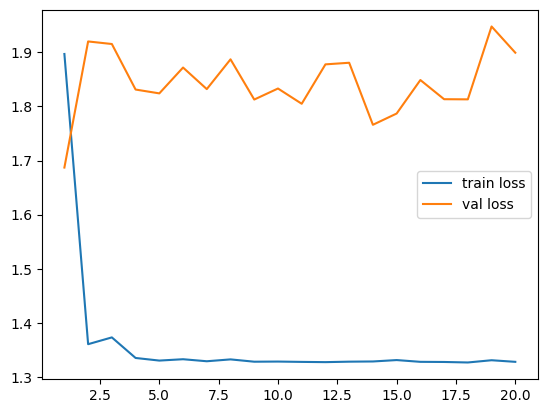

In [62]:
# loss 시각화

plt.plot([ep for ep in range (1, 21)],
        [component[0] for component in loss_history],
        label='train loss')
plt.plot([ep for ep in range (1, 21)],
        [component[1] for component in loss_history],
        label='val loss')
plt.legend()
plt.show()